import data and inspect

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import make_interp_spline
from scipy.stats import chi2_contingency
import seaborn as sns
import altair as alt

In [ ]:
#C:\Users\Acer\Documents\DataSprint\data\DataWaveDataSet.csv
file = r"C:\Users\Acer\Documents\DataSprint\data\DataWaveDataSet.csv"

df = pd.read_csv(file)

df.head()
df.info()
df.shape
df.describe()


df.isnull().sum()

Cleaning the user_id

In [ ]:
df['user_id'].duplicated().sum()

df = df.drop_duplicates(subset=['user_id'])

df = df.dropna(subset=['user_id'])


cleaned_file = r"C:\Users\Acer\Documents\DataSprint\data\cleaned.csv"
df.to_csv(cleaned_file, index=False)


save the new csv


In [54]:
cleaned_file = r"C:\Users\Acer\Documents\DataSprint\data\cleaned.csv"
df.to_csv(cleaned_file, index=False)

In [2]:
cleaned_file = r"C:\Users\Acer\Documents\DataSprint\data\cleaned.csv"
df = pd.read_csv(cleaned_file)

cleaning the gender and country column

In [ ]:
df = pd.read_csv(cleaned_file)

df ['gender'].isnull().sum()

#dropping the null values
df = df.dropna(subset=['gender'])

df['gender'] = df['gender'].astype(str).str.lower().str.strip()

gender_map = {
    'f' : 'Female',
    'female': 'Female',

    'm' : 'Male',
    'male': 'Male',

    'other' : 'Other'
}

df['gender'] = df['gender'].map(gender_map)


df['country'].isnull().sum()

df['country'] = (df['country'].astype(str).str.lower().str.strip().str.replace('.', '', regex = False))

country_map = {
    'uk' : 'United Kingdom',
    'united kingdom' : 'United Kingdom',
    'usa' : 'United States',
    'ind' : 'India',
}

df['country'] = df['country'].map(country_map).fillna(df['country'])
df['country'] = df['country'].str.title()




In [19]:
# df = pd.read_csv(cleaned_file)
cleaned_file = r"C:\Users\Acer\Documents\DataSprint\data\cleaned.csv"
df.to_csv(cleaned_file, index=False)


subscription_type cleaning

In [ ]:
df['subscription_type'].unique()

df['subscription_type'] = (df['subscription_type'].astype(str).str.lower().str.strip())

subscription_map = {
    'studnt' : 'student',
    'fam' : 'family',
    'premum' : 'premium',
}

df['subscription_type'] = df['subscription_type'].map(subscription_map).fillna(df['subscription_type'])
df['subscription_type'] = df['subscription_type'].str.title()



array(['Premium', 'Student', 'Family', 'Free'], dtype=object)

Inspect and cleaning satisfaction_score & skip rate

In [5]:
df = df.dropna(subset=['satisfaction_score'])



In [ ]:
def clean_skip_rate(x):
    x = str(x).strip().lower()

    if "%" in x:
        x = x.replace("%", "")
        return pd.to_numeric(x, errors="coerce") / 100

    num = pd.to_numeric(x, errors="coerce")
    if pd.notna(num):
        return num

    words = {
        "zero": 0,
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "five": 5,
        "six": 6,
        "seven": 7,
        "eight": 8,
        "nine": 9,
        "ten": 10
    }

    if x in words:
        return words[x]

    return np.nan


df["skip_rate"] = df["skip_rate"].apply(clean_skip_rate)

df["skip_rate"] = df["skip_rate"].apply(
    lambda x: x/100 if pd.notna(x) and x > 1 else x
)

df[["skip_rate"]].head()


mapping churned

In [13]:
df['churned'].unique()

df['churned'] = (df['churned'].astype(str).str.capitalize().str.strip())

churned_map ={
    '1' : 'Yes',
    '0' : 'No',
}

df['churned'] = df['churned'].map(churned_map).fillna(df['churned'])


cleaning monthly_fee

In [ ]:
def clean_monthly_fee(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    x = x.replace("usd", "").replace("$", "").strip()

    num = pd.to_numeric(x, errors = 'coerce')
    if pd.notna(num):
        return num
    if x in ["free", "none", "no fee"]:
        return 0.0
    return np.nan 
df['monthly_fee_clean'] = df['monthly_fee'].apply(clean_monthly_fee)

df[['monthly_fee', 'monthly_fee_clean']].head()

cleaning join_date

In [27]:
def clean_date(x):
    if pd.isna(x):
        return pd.NaT
    
    x = str(x).strip()
    parts = x.replace('-', '/').split('/')
    try:
        day = int(parts[0])
        month = int(parts[1])
    except:
        return pd.NaT

    if day > 12:
        try:
            return pd.to_datetime(x, format='%d/%m/%Y', errors='coerce')
        except:
            return pd.NaT
    if month > 12:
        try:
            return pd.to_datetime(x, format='%m/%d/%Y', errors='coerce')
        except:
            return pd.NaT

    try:
        return pd.to_datetime(x, dayfirst=True, errors='coerce')
    except:
        return pd.NaT


Exploring

In [ ]:
df.columns


Index(['user_id', 'country', 'age', 'gender', 'subscription_type',
       'avg_listening_hours_per_week', 'total_songs_played', 'skip_rate',
       'satisfaction_score', 'churned', 'monthly_fee', 'join_date',
       'monthly_fee_clean'],
      dtype='object')

In [9]:
df['country'].unique()

array(['Nepal', 'United States', 'Nigeria', 'Ghana', 'United Kingdom',
       'India', 'Kenya', 'Brazil', 'South Africa'], dtype=object)

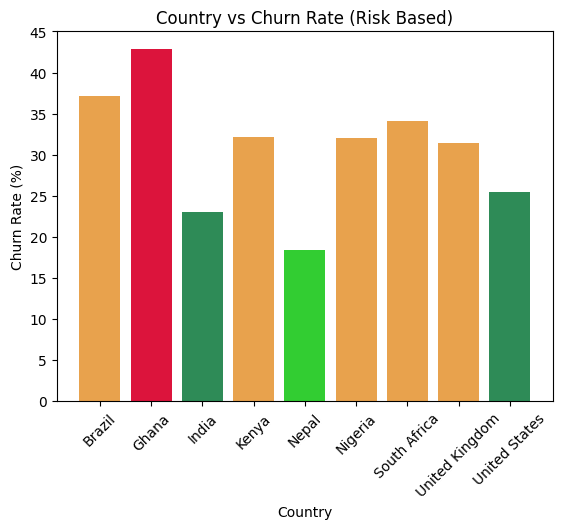

In [ ]:
churn_rate = df.groupby("country")["churned"].mean() * 100

def risk_color(rate):
    if rate >= 40:
        return "#DC143C"
    elif rate >= 30:
        return "#E8A24D"
    elif rate >=20:
        return "#2E8B57"
    else:
        return "#32CD32"

# Apply color for each country
colors = [risk_color(rate) for rate in churn_rate.values]

# Plot
plt.figure()
plt.bar(churn_rate.index, churn_rate.values, color=colors)
plt.xticks(rotation=45)
plt.xlabel("Country")
plt.ylabel("Churn Rate (%)")
plt.title("Country vs Churn Rate (Risk Based)")
plt.show()

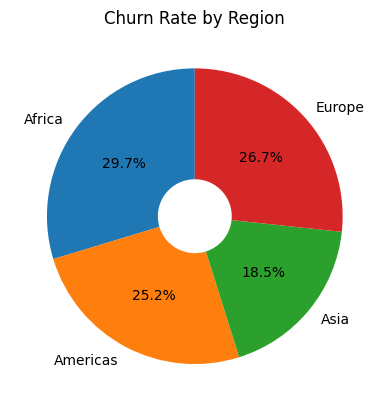

In [ ]:
region_churn = df.groupby('region')['churned'].mean() * 100

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    region_churn,
    labels=region_churn.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width':0.75}
)

plt.title("Churn Rate by Region")

plt.show()


subscription_type  Family  Free  Premium  Student
age_group                                        
13-18                38.0  33.0     42.0     29.0
18-24                37.0  25.0     29.0     41.0
25-34                28.0  23.0     26.0     19.0
35-44                24.0  33.0     32.0     28.0
45-54                22.0  22.0     25.0     32.0
55-64                37.0  24.0     32.0     38.0


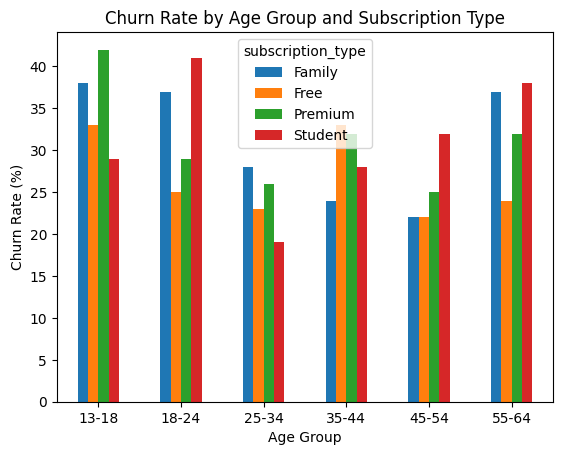

In [27]:
churn_rate_age_sub = df.groupby(['age_group','subscription_type'])['churned'].mean().round(2) * 100


churn_table = churn_rate_age_sub.unstack()

print(churn_table)

churn_table.plot(kind='bar')

plt.xlabel("Age Group")
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Age Group and Subscription Type")
plt.xticks(rotation=0)
plt.show()

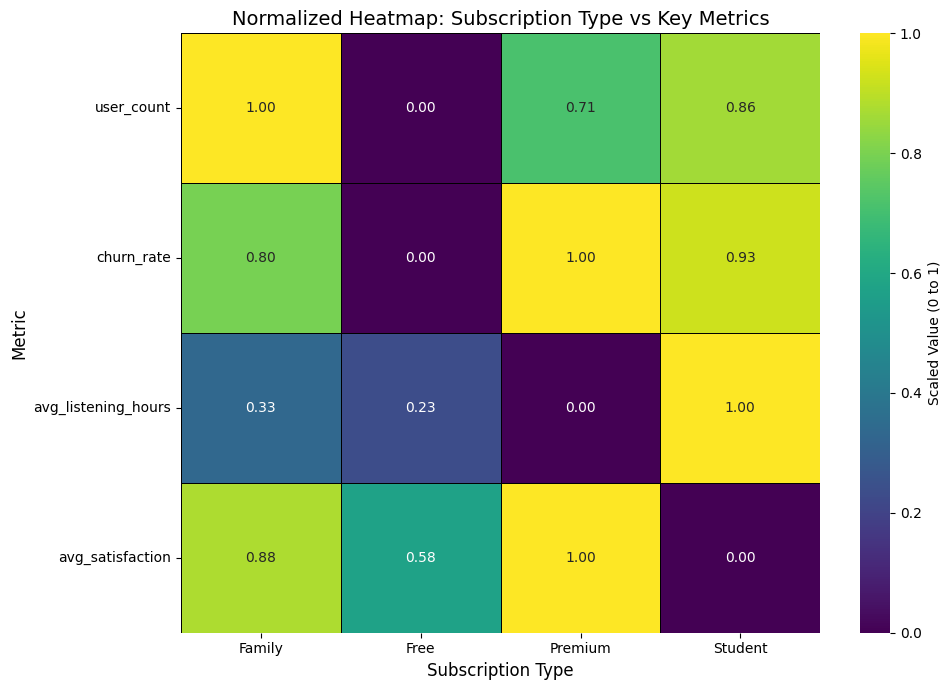

In [50]:
df['churned'] = df['churned'].astype(int)

summary = df.groupby('subscription_type').agg(
    user_count=('subscription_type', 'count'),
    churn_rate=('churned', 'mean'),
    avg_listening_hours=('avg_listening_hours_per_week', 'mean'),
    avg_satisfaction=('satisfaction_score', 'mean') 
)

summary['churn_rate'] = summary['churn_rate'] * 100

def min_max_scale(series):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return np.zeros_like(series)
    return (series - min_val) / (max_val - min_val)

scaled_summary = summary.apply(min_max_scale, axis=0)

plt.figure(figsize=(10, 7))
sns.heatmap(
    scaled_summary.T,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': 'Scaled Value (0 to 1)'}
)

plt.title("Normalized Heatmap: Subscription Type vs Key Metrics", fontsize=14)
plt.ylabel('Metric', fontsize=12)
plt.xlabel('Subscription Type', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

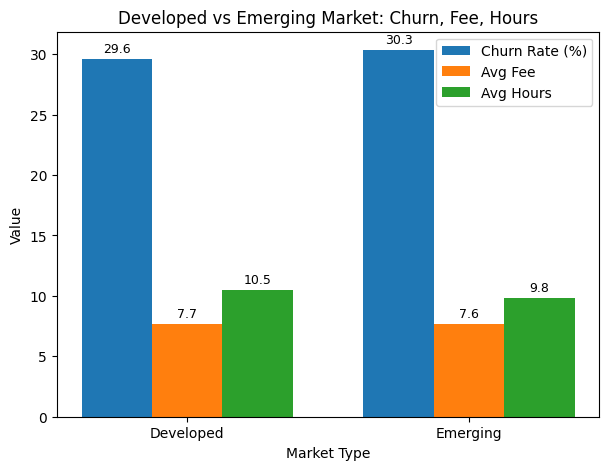

In [65]:
summary = df.groupby('market').agg(
    churn_rate=('churned', 'mean'),          
    avg_fee=('monthly_fee_clean', lambda x: x.dropna().mean()), 
    avg_hours=('avg_listening_hours_per_week', 'mean')
)

summary['churn_rate'] = summary['churn_rate'] * 100

summary = summary.reset_index()

x = np.arange(len(summary['market']))
width = 0.25

fig, ax = plt.subplots(figsize=(7,5))

# Plot bars
bars1 = ax.bar(x - width, summary['churn_rate'], width, label='Churn Rate (%)')
bars2 = ax.bar(x, summary['avg_fee'], width, label='Avg Fee')
bars3 = ax.bar(x + width, summary['avg_hours'], width, label='Avg Hours')

# Add values on top of bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2, 
            height + 0.3,                 
            f'{height:.1f}',                 
            ha='center', va='bottom', fontsize=9
        )

ax.set_xlabel('Market Type')
ax.set_ylabel('Value')
ax.set_title('Developed vs Emerging Market: Churn, Fee, Hours')
ax.set_xticks(x)
ax.set_xticklabels(summary['market'])
ax.legend()

plt.show()

In [ ]:
regional_summary = df.groupby('region').agg(
    Users=('region', 'count'),
    Churn=('churned', 'mean'),
    Avg_Hours=('avg_listening_hours_per_week', 'mean'),
    Satisfaction=('satisfaction_score', 'mean'),
    Skip_Rate=('skip_rate', 'mean')
).round(2)

# Convert churn to %
regional_summary['Churn'] = regional_summary['Churn'] * 100
regional_summary['Skip_Rate'] = regional_summary['Skip_Rate'] * 100

regional_summary = regional_summary.reset_index()

print(regional_summary)

     region  Users  Churn  Avg_Hours  Satisfaction  Skip_Rate
0    Africa    192   35.0       9.84          3.09       18.0
1  Americas     98   30.0      10.33          3.14       17.0
2      Asia    129   22.0       9.40          3.10       15.0
3    Europe    153   31.0      10.70          3.29       17.0


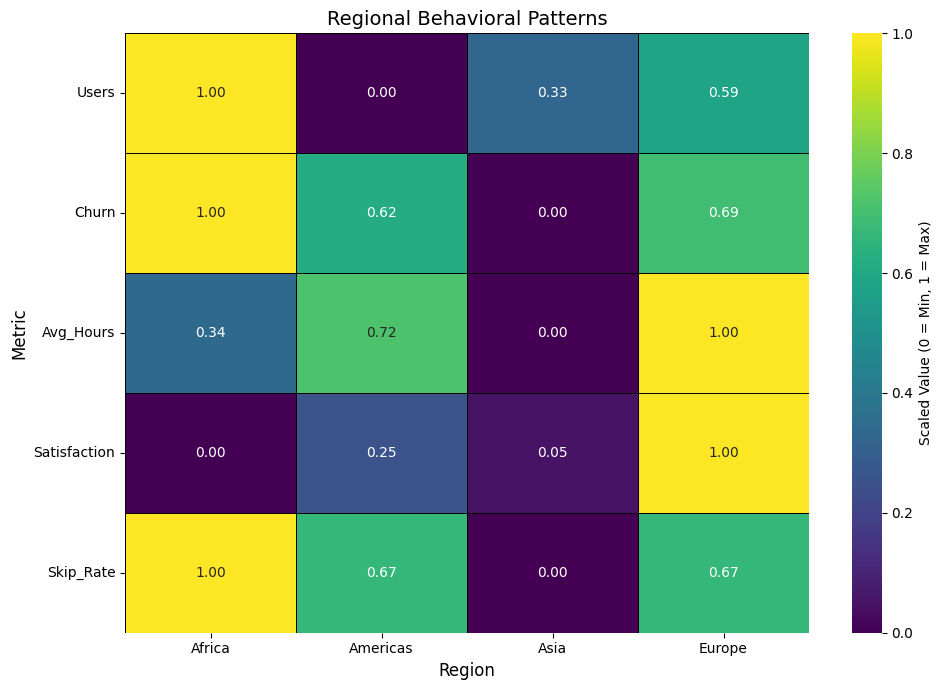

In [73]:
metrics_cols = regional_summary.columns.drop('region')

def min_max_scale(series):
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return np.zeros_like(series)
    return (series - min_val) / (max_val - min_val)

scaled_metrics = regional_summary[metrics_cols].apply(min_max_scale, axis=0)
scaled_regional_summary = pd.concat([regional_summary['region'], scaled_metrics], axis=1)

plot_data = scaled_regional_summary.set_index('region').T

plt.figure(figsize=(10, 7))
sns.heatmap(
    plot_data,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=.5,
    linecolor='black',
    cbar_kws={'label': 'Scaled Value (0 = Min, 1 = Max)'}
)

plt.title("Regional Behavioral Patterns", fontsize=14)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Metric', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
import pandas as pd

# Load the data
df = pd.read_csv('data/cleaned.csv')

# Parse join_date properly (handles both MM/DD/YYYY and DD/MM/YYYY formats)
df['join_date'] = pd.to_datetime(df['join_date'], dayfirst=True, errors='coerce')

# Remove any rows where date parsing failed (should be none in your file)
df = df.dropna(subset=['join_date'])

# Create quarterly "join_year" exactly like in the chart: 2022.00, 2022.25, 2022.50, etc.
df['join_year_quarter'] = df['join_date'].dt.year + (df['join_date'].dt.quarter - 1) * 0.25

# Group and calculate
grouped = df.groupby('join_year_quarter').agg(
    user_count=('user_id', 'count'),
    churned_count=('churned', 'sum')
).reset_index()

grouped['churn_rate_pct'] = (grouped['churned_count'] / grouped['user_count']) * 100
grouped['churn_rate_pct'] = grouped['churn_rate_pct'].round(2)

# Sort by quarter
grouped = grouped.sort_values('join_year_quarter')

result = grouped[grouped['join_year_quarter'] <= 2024.5].copy()

# Rename for nice output
result = result.rename(columns={'join_year_quarter': 'Join Year'})

# Print clean table
print(result[['Join Year', 'user_count', 'churn_rate_pct']].to_string(index=False))

 Join Year  user_count  churn_rate_pct
   2022.00          33           18.18
   2022.25          32           28.12
   2022.50          39           30.77
   2022.75          44           34.09
   2023.00          39           25.64
   2023.25          40           30.00
   2023.50          39           35.90
   2023.75          33           33.33
   2024.00          26           34.62
   2024.25          21           38.10
   2024.50          18           27.78


C:\Users\Acer\AppData\Local\Temp\ipykernel_19324\2829148064.py:7: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['join_date'] = pd.to_datetime(df['join_date'], dayfirst=True, errors='coerce')


C:\Users\Acer\AppData\Local\Temp\ipykernel_18316\4158236357.py:1: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['join_date'] = pd.to_datetime(df['join_date'], dayfirst=True, errors='coerce')


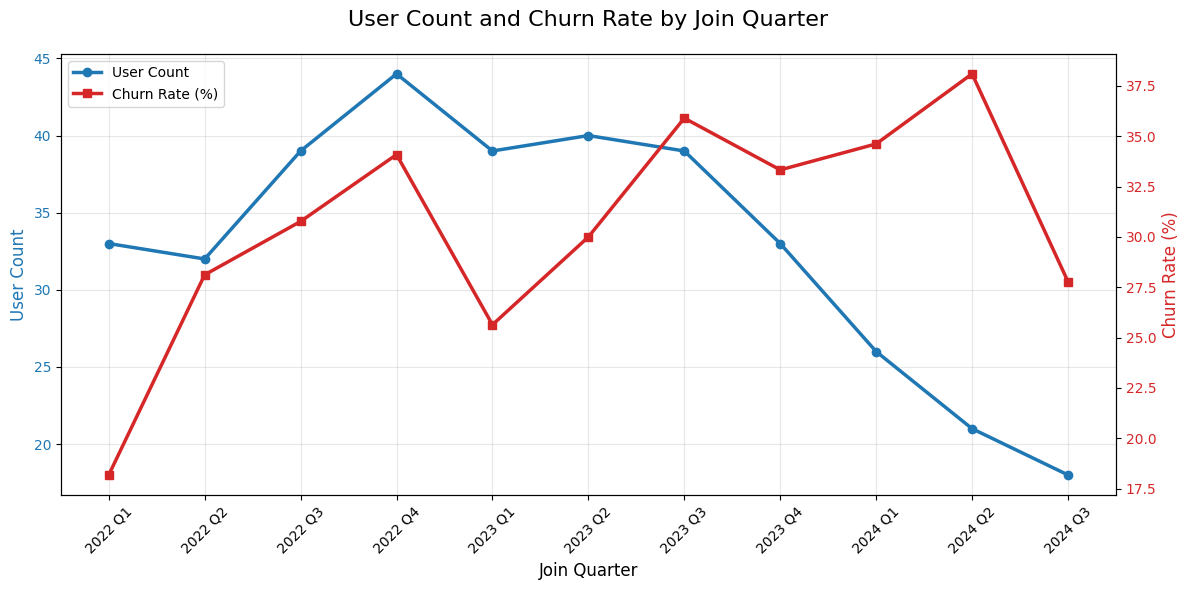

In [3]:
df['join_date'] = pd.to_datetime(df['join_date'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['join_date'])

df['join_year_quarter'] = df['join_date'].dt.year + (df['join_date'].dt.quarter - 1) * 0.25

grouped = df.groupby('join_year_quarter').agg(
    user_count=('user_id', 'count'),
    churned_count=('churned', 'sum')
).reset_index()

grouped['churn_rate_pct'] = (grouped['churned_count'] / grouped['user_count']) * 100
grouped['churn_rate_pct'] = grouped['churn_rate_pct'].round(2)
grouped = grouped.sort_values('join_year_quarter')


grouped = grouped[grouped['join_year_quarter'] <= 2024.5]
fig, ax1 = plt.subplots(figsize=(12, 6))

color1 = 'tab:blue'
ax1.set_xlabel('Join Quarter', fontsize=12)
ax1.set_ylabel('User Count', color=color1, fontsize=12)
line1 = ax1.plot(grouped['join_year_quarter'], grouped['user_count'],
                 color=color1, marker='o', linewidth=2.5, label='User Count')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Churn Rate (%)', color=color2, fontsize=12)
line2 = ax2.plot(grouped['join_year_quarter'], grouped['churn_rate_pct'],
                 color=color2, marker='s', linewidth=2.5, label='Churn Rate (%)')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('User Count and Churn Rate by Join Quarter', fontsize=16, pad=20)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

quarter_labels = [
    f"{int(year)} Q{int((q-year)*4 + 1)}"
    for year, q in zip(grouped['join_year_quarter'] // 1, grouped['join_year_quarter'])
]
ax1.set_xticks(grouped['join_year_quarter'])
ax1.set_xticklabels(quarter_labels, rotation=45)

fig.tight_layout()
plt.show()

In [35]:
correlation = df['skip_rate'].corr(df['churned'])
print(f"Correlation between skip rate and churn: {correlation:.2f}")

Correlation between skip rate and churn: 0.04


In [36]:
skip_summary = df.groupby('churned').agg(
    avg_skip_rate=('skip_rate', 'mean'),
    median_skip_rate=('skip_rate', 'median'),
    total_users=('user_id', 'count')
).reset_index()

skip_summary['avg_skip_rate'] = skip_summary['avg_skip_rate'].round(2)
skip_summary['median_skip_rate'] = skip_summary['median_skip_rate'].round(2)

print(skip_summary.to_string(index=False))

 churned  avg_skip_rate  median_skip_rate  total_users
       0           0.16              0.15          258
       1           0.17              0.15          111


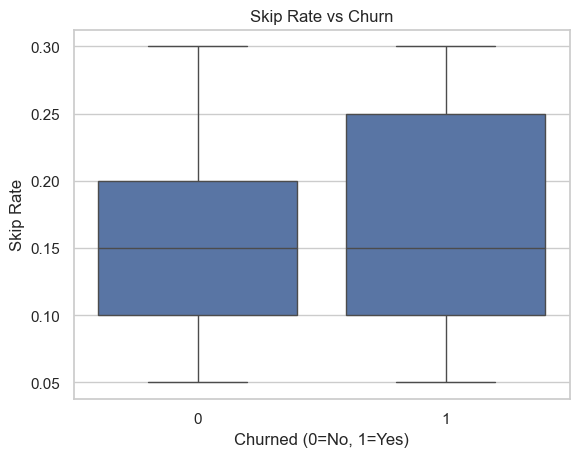

In [37]:

sns.boxplot(x='churned', y='skip_rate', data=df)
plt.title("Skip Rate vs Churn")
plt.xlabel("Churned (0=No, 1=Yes)")
plt.ylabel("Skip Rate")
plt.show()

age_group  user_count  churned_count  churn_rate_pct
    13-18          40             16           40.00
    18-24          55             17           30.91
    25-34          52             11           21.15
    35-44          77             22           28.57
    45-54          76             19           25.00
    55-64          69             26           37.68


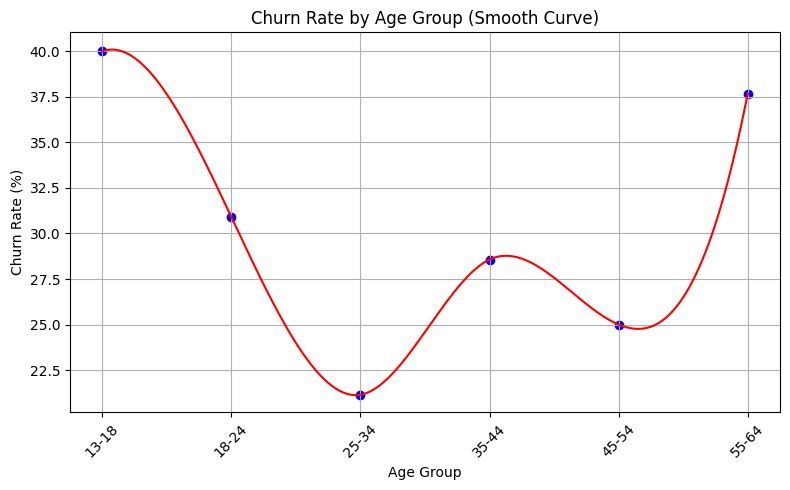

In [ ]:
age_risk = df.groupby('age_group').agg(
    user_count=('user_id', 'count'),
    churned_count=('churned', 'sum')
).reset_index()

age_risk['churn_rate_pct'] = (age_risk['churned_count'] / age_risk['user_count']) * 100
age_risk['churn_rate_pct'] = age_risk['churn_rate_pct'].round(2)

print(age_risk.to_string(index=False))

x = np.arange(len(age_risk['age_group']))
y = age_risk['churn_rate_pct']

x_smooth = np.linspace(x.min(), x.max(), 300)
spl = make_interp_spline(x, y, k=3) 
y_smooth = spl(x_smooth)


plt.figure(figsize=(8,5))
plt.plot(x_smooth, y_smooth, color='red')
plt.scatter(x, y, color='blue')
plt.xticks(x, age_risk['age_group'], rotation=45)
plt.xlabel("Age Group")
plt.ylabel("Churn Rate (%)")
plt.title("Churn Rate by Age Group")
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
recent_churn = df.groupby('skip_rate').agg(
    user_count=('user_id', 'count'),
    churned_count=('churned', 'sum')
).reset_index()

recent_churn['churn_rate_pct'] = (recent_churn['churned_count'] / recent_churn['user_count']) * 100
recent_churn['churn_rate_pct'] = recent_churn['churn_rate_pct'].round(2)

print(recent_churn.to_string(index=False))

 skip_rate  user_count  churned_count  churn_rate_pct
      0.05          42              9           21.43
      0.10         114             42           36.84
      0.15          44              6           13.64
      0.20          86             24           27.91
      0.25          42             15           35.71
      0.30          41             15           36.59


In [ ]:
from datetime import datetime

# Current date (or analysis date)
today = pd.to_datetime('today')

# Tenure in months
df['tenure_months'] = (today.year - df['join_date'].dt.year) * 12 + (today.month - df['join_date'].dt.month)




In [8]:
status_quo = df[(df['tenure_months'] > 12) & (df['satisfaction_score'] <= 2)]
status_quo_count = len(status_quo)
status_quo_pct = status_quo_count / len(df[df['tenure_months'] > 12]) * 100
print(f"Status Quo Bias: {status_quo_count} users, {status_quo_pct:.1f}% of long-tenure users")

Status Quo Bias: 98 users, 26.8% of long-tenure users


In [11]:
sunk_cost = df[(df['monthly_fee_clean'] > 9) & (df['satisfaction_score'] <= 2)]
active_sunk_cost = sunk_cost[sunk_cost['churned']==0]
active_pct = len(active_sunk_cost)/len(sunk_cost)*100
print(f"Sunk Cost Fallacy: {len(sunk_cost)} users, {active_pct:.1f}% still active")


Sunk Cost Fallacy: 43 users, 72.1% still active


      region subscription_type  users
0     Africa            Family     35
1     Africa              Free     22
2     Africa           Premium     37
3     Africa           Student     35
4   Americas            Family     19
5   Americas              Free      6
6   Americas           Premium     15
7   Americas           Student     15
8       Asia            Family     31
9       Asia              Free      6
10      Asia           Premium     20
11      Asia           Student     24
12    Europe            Family     32
13    Europe              Free     17
14    Europe           Premium     22
15    Europe           Student     33


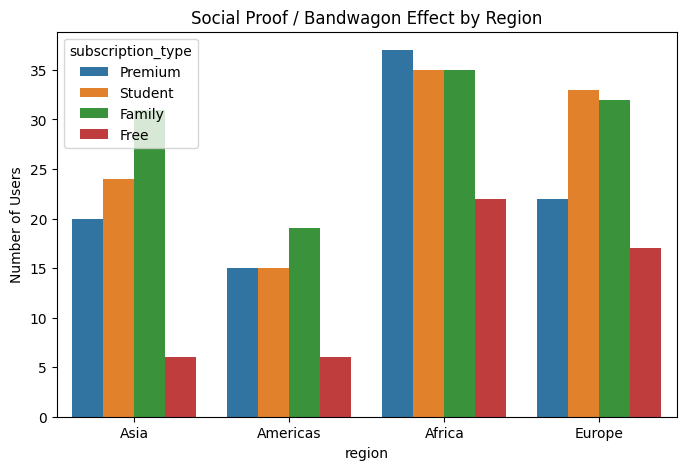

In [13]:
region_summary = df.groupby(['region','subscription_type']).agg(
    users=('user_id','count')
).reset_index()
print(region_summary)

# Optional: stacked bar chart
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='region', hue='subscription_type')
plt.title("Social Proof / Bandwagon Effect by Region")
plt.ylabel("Number of Users")
plt.show()

                User Type  Churn Rate  Avg Satisfaction
0  Early Adopters (<2023)       28.38              3.25
1   Later Joiners (2023+)       31.22              3.14


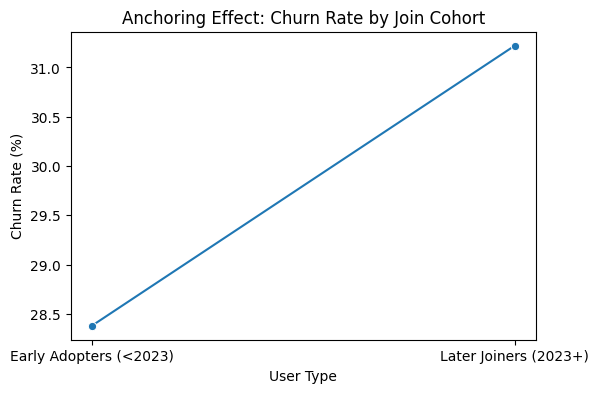

In [15]:
df['join_year'] = df['join_date'].dt.year
early = df[df['join_year'] < 2023]
late = df[df['join_year'] >= 2023]

anchoring_summary = pd.DataFrame({
    'User Type': ['Early Adopters (<2023)', 'Later Joiners (2023+)'],
    'Churn Rate': [early['churned'].mean()*100, late['churned'].mean()*100],
    'Avg Satisfaction': [early['satisfaction_score'].mean(), late['satisfaction_score'].mean()]
})
anchoring_summary['Churn Rate'] = anchoring_summary['Churn Rate'].round(2)
anchoring_summary['Avg Satisfaction'] = anchoring_summary['Avg Satisfaction'].round(2)
print(anchoring_summary)

# Line chart
plt.figure(figsize=(6,4))
sns.lineplot(x='User Type', y='Churn Rate', data=anchoring_summary, marker='o')
plt.title("Anchoring Effect: Churn Rate by Join Cohort")
plt.ylabel("Churn Rate (%)")
plt.show()


Free Tier High Engagement Users Churn Rate: 23.5%


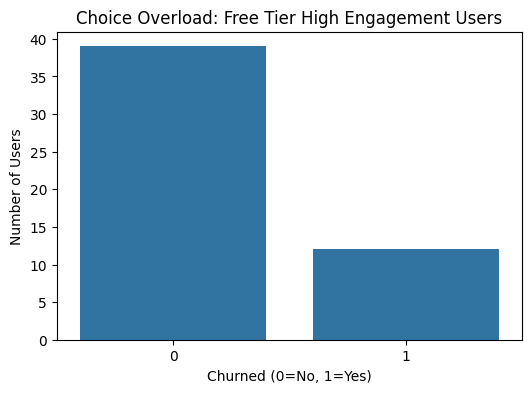

In [16]:
free_high_engagement = df[(df['subscription_type']=='Free') & (df['total_songs_played']>100)]  # adjust threshold
churn_rate_free = free_high_engagement['churned'].mean()*100
print(f"Free Tier High Engagement Users Churn Rate: {churn_rate_free:.1f}%")

# Bar chart
plt.figure(figsize=(6,4))
sns.countplot(x='churned', data=free_high_engagement)
plt.title("Choice Overload: Free Tier High Engagement Users")
plt.xlabel("Churned (0=No, 1=Yes)")
plt.ylabel("Number of Users")
plt.show()

In [17]:
status_quo_summary = pd.DataFrame({
    'Bias': ['Status Quo Bias'],
    'Users': [status_quo_count],
    'Pct of long-tenure users': [round(status_quo_pct,2)]
})

sunk_cost_summary = pd.DataFrame({
    'Bias': ['Sunk Cost Fallacy'],
    'Users': [len(sunk_cost)],
    'Pct Active': [round(active_pct,2)]
})

anchoring_summary.to_csv("anchoring_summary.csv", index=False)
status_quo_summary.to_csv("status_quo_summary.csv", index=False)
sunk_cost_summary.to_csv("sunk_cost_summary.csv", index=False)
region_summary.to_csv("region_summary.csv", index=False)

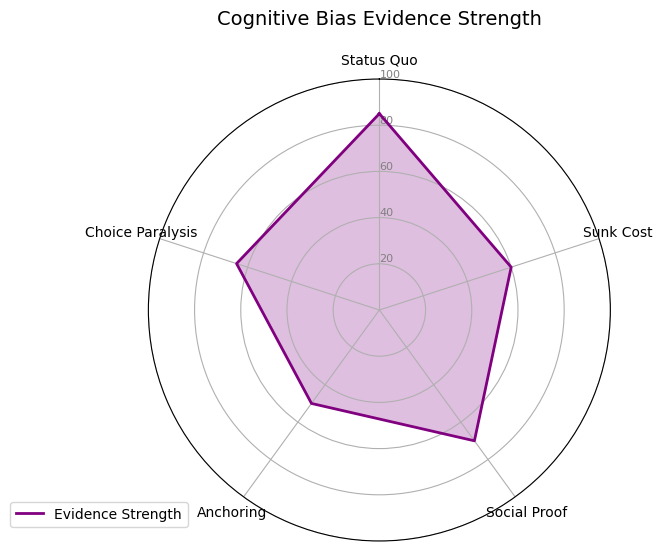

In [18]:
labels = ['Status Quo', 'Sunk Cost', 'Social Proof', 'Anchoring', 'Choice Paralysis']

# Example evidence strength values (replace with your real %)
values = [85, 60, 70, 50, 65]  # these are percentages
num_vars = len(labels)

# Repeat the first value to close the circle
values += values[:1]
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

# Initialize plot
fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))

# Draw one axe per variable + add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], labels)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([20,40,60,80,100], ["20","40","60","80","100"], color="grey", size=8)
plt.ylim(0,100)

# Plot data
ax.plot(angles, values, color="purple", linewidth=2, linestyle='solid', label="Evidence Strength")
ax.fill(angles, values, color="purple", alpha=0.25)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.title("Cognitive Bias Evidence Strength", size=14, y=1.1)
plt.show()

In [6]:
churn_rate = (df['churned'] == 1).mean().round(2)* 100
print("Overall Churn Rate:", churn_rate)


Overall Churn Rate: 30.0


In [8]:
retention_rate = 100 - churn_rate
print("Overall Retention Rate:", retention_rate)

Overall Retention Rate: 70.0


In [13]:
avg_listening = df['avg_listening_hours_per_week'].mean().round(2)
print("Average Weekly Listening:", avg_listening, "hr")


Average Weekly Listening: 10.03 hr


In [12]:
avg_satisfaction = df['satisfaction_score'].mean().round(2)
print("Average Satisfaction Score:", avg_satisfaction)


Average Satisfaction Score: 3.18


In [14]:
summary_table = pd.DataFrame({
    "Metric": [
        "Overall Churn Rate",
        "Retention Rate",
        "Avg Weekly Listening (hrs)",
        "Avg Satisfaction Score"
    ],
    "Value": [
        f"{churn_rate:.2f}%",
        f"{retention_rate:.2f}%",
        round(avg_listening, 2),
        round(avg_satisfaction, 2)
    ]
})

summary_table

,Metric,Value
0,Overall Churn Rate,30.00%
1,Retention Rate,70.00%
2,Avg Weekly Listening (hrs),10.03
3,Avg Satisfaction Score,3.18


In [13]:
churn_rate_by_satisfaction = df.groupby('satisfaction_score')['churned'].mean().reset_index()
churn_rate_by_satisfaction.rename(columns={'churned': 'churn_rate'}, inplace=True)

churn_rate_by_satisfaction['satisfaction_score'] = churn_rate_by_satisfaction['satisfaction_score'].astype(int)

churn_rate_by_satisfaction = churn_rate_by_satisfaction.sort_values('satisfaction_score')

def churn_color(rate):
    if rate < 0.3:
        return "green"
    elif rate < 0.32:
        return "orange"
    else:
        return "red"

churn_rate_by_satisfaction['color'] = churn_rate_by_satisfaction['churn_rate'].apply(churn_color)

chart = alt.Chart(churn_rate_by_satisfaction).mark_bar().encode(
    x=alt.X('satisfaction_score:O', title='Satisfaction Score'),
    y=alt.Y('churn_rate:Q', title='Churn Rate', axis=alt.Axis(format='.1%')),
    color=alt.Color('color:N', scale=None, legend=None),
    tooltip=[
        alt.Tooltip('satisfaction_score:O', title='Satisfaction Score'),
        alt.Tooltip('churn_rate:Q', title='Churn Rate', format='.2%')
    ]
).properties(
    title='Churn Rate by Customer Satisfaction Score',
    width=600
).interactive()

chart

alt.Chart(...)

In [19]:
cols = ['total_songs_played', 'satisfaction_score', 'monthly_fee_clean', 'age', 'avg_listening_hours_per_week', 'churned']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

correlation_with_churn = df[cols].corr()['churned'].drop('churned').reset_index()
correlation_with_churn.columns = ['Variable', 'Correlation with Churn']
correlation_with_churn['Correlation with Churn'] = correlation_with_churn['Correlation with Churn'].round(2)

def color_coding(val):
    if val < 0:
        return 'background-color: green; color: white'
    elif val > 0:
        return 'background-color: orange; color: white'
    else:
        return 'background-color: white; color: black'

styled_table = correlation_with_churn.style.applymap(color_coding, subset=['Correlation with Churn'])
styled_table

C:\Users\Acer\AppData\Local\Temp\ipykernel_9184\3585873167.py:16: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_table = correlation_with_churn.style.applymap(color_coding, subset=['Correlation with Churn'])


,Variable,Correlation with Churn
0,total_songs_played,0.020000
1,satisfaction_score,0.050000
2,monthly_fee_clean,-0.020000
3,age,-0.010000
4,avg_listening_hours_per_week,0.000000


In [20]:
country_sub = df.groupby(['country', 'subscription_type']).size().reset_index(name='count')

chart = alt.Chart(country_sub).mark_bar().encode(
    x=alt.X('country:N', title='Country'),
    y=alt.Y('count:Q', title='Number of Users'),
    color=alt.Color('subscription_type:N', title='Subscription Type'),
    column=alt.Column('subscription_type:N', header=alt.Header(labelAngle=0)),  # optional: separate by subscription type
    tooltip=['country', 'subscription_type', 'count']
).properties(
    title='Number of Users by Country and Subscription Type',
    width=150
).interactive()

chart

alt.Chart(...)